In [1]:
import sys
sys.path.append('..')
import numpy as np
import pickle
from scipy.io import savemat
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker 
from matplotlib.gridspec import GridSpec
from tqdm import tqdm

### Load data

In [2]:
srate = 250
expName = 'sweep'

dir = '../datasets/%s.pickle' % expName
winLENs = np.arange(0.2, 1, step=.2)
with open(dir, "rb") as fp:
    wholeset = pickle.load(fp)

sub = wholeset[4]

chnNames = ['PZ', 'PO5', 'POZ', 'PO4', 'PO6', 'O1', 'OZ','O2']
chnINX = [sub['channel'].index(i) for i in chnNames]
X = sub['wn']['X'][:,chnINX]
y = sub['wn']['y']
S = sub['wn']['STI']
sub['name']

'shinanlin'

_Variable defination_:
- $X$: EEG data, shape as $epoch \times channel \times T$
- $S$: STI sequence, shape as $class \times T$
- $y$: Event labels, shape as $epoch \times 1$

### define model parameters

In [29]:
srate = 250
winLEN = 3
classNUM = 160
tmin, tmax = 0, .8
n_band = 3
# penalty
p = 0.9

## Split dataset

In [44]:
# reshape to class*block*chn*N
X_ = np.stack(X[y == i] for i in np.unique(y))
y_ = np.stack(y[y == i] for i in np.unique(y))

# split conditions
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_, y_,test_size=0.5,train_size=0.5,random_state=253)

X_train,X_test = np.concatenate(X_train, axis=0), np.concatenate(X_test, axis=0)
y_train,y_test = np.concatenate(y_train, axis=0), np.concatenate(y_test, axis=0)
S_train,S_test = np.stack([S[i-1] for i in y_train]),np.stack([S[i-1] for i in y_test])

# Fit a forward model

The key to fit a powerful Code2EEG mode is to train by spatially filtered epoch, instead of single epoch ones.

You can start the model by `Code2EEG().fit()`.
1. initialize Code2EEG() class with stimulation sequence:`Code2EEG(S=(STI,np.unique(y))) `
2. `fit(X,y)` takes two parameters
    * $X$: EEG data, shape as $epoch \times channel \times T$ and y
    * $y$: Event labels, shape as $epoch \times 1$
    

In [45]:
from modeling import Code2EEG
code2EEG = Code2EEG(srate=srate,winLEN=winLEN,tmin=tmin,tmax=tmax,S=(S,np.unique(y)),estimator=p,padding=True,n_band=n_band,component=1)
code2EEG.fit(X_train,y_train)

## Predict unseen response

In [56]:
R_ = code2EEG.predict(S_test)
R = code2EEG.enhancer.transform(X_test)

we can inspect a few properties, for example:

1. `code2EEG.trf`: trf in each band, we can reconstruct 
2. `code2EEG.enhanced`: enhanced response for each class
3. `code2EEG.predict(S_test)`: reconstructed response for each test STI seq
4. `code2EEG.enhancer.transform(X_test)`: transform multi-channel response to enhanced response

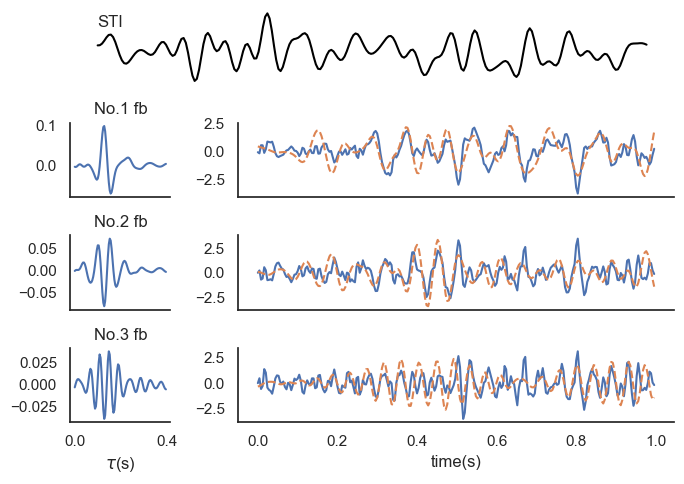

In [47]:
inx = 2
sns.set_theme(style='white')
# plt.rcParams['text.usetex'] = True


fig = plt.figure(figsize=(7,5))
# set up subplot grid
GridSpec(4, 4)
# large subplot
ax1 = plt.subplot2grid((4, 4), (0, 0), colspan=4, rowspan=1)
ax1.plot(S[inx],color='black')
ax1.set_axis_off()
ax1.text(x=0,y=1,s='STI')

for i in range(n_band):

    ax_k = plt.subplot2grid((4, 4), (i+1, 0), colspan=1, rowspan=1)
    
    ax_k.plot(code2EEG.trf[i, :100])
    
    ax_x = plt.subplot2grid((4, 4), (i+1, 1), colspan=3, rowspan=1)
    ax_x.plot(R[inx][i].T,label='pattern')
    ax_x.plot(R_[inx][i].T, linestyle='dashed',label = 'reconstructed')
    ax_k.set_title('No.%s fb'%(i+1))

    # if i == 0:
        # ax_x.legend(loc='upper right', bbox_to_anchor=(1, 1))

    if i != n_band-1:
        ax_k.xaxis.set_major_formatter(ticker.NullFormatter())
        ax_x.xaxis.set_major_formatter(ticker.NullFormatter())
    else:
        ax_k.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: "%.1f" % (x/240)))
        ax_x.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: "%.1f" % (x/240)))

    

ax_k.set_xlabel(r'$\tau$(s)')
ax_x.set_xlabel('time(s)')

sns.despine()
plt.tight_layout()
# plt.savefig('../images/code2eeg.png',format='png',dpi=300)

### Visualize confusion matrix of real and reconstruted response

In [64]:
R_ave = np.stack([R[y_test == i] for i in np.unique(y_test)]).mean(axis=1)
R_ave_ = np.stack([R_[y_test == i] for i in np.unique(y_test)]).mean(axis=1)
rhos = np.zeros((n_band, R_ave.shape[0], R_ave_.shape[0]))
for i, r in enumerate(R_ave):
    for j,r_ in enumerate(R_ave_):
        for fbINX, (fb_r,fb_r_) in enumerate(zip(r,r_)):
            rho = np.corrcoef(fb_r, fb_r_)[0, 1]
            rhos[fbINX,i,j] = rho

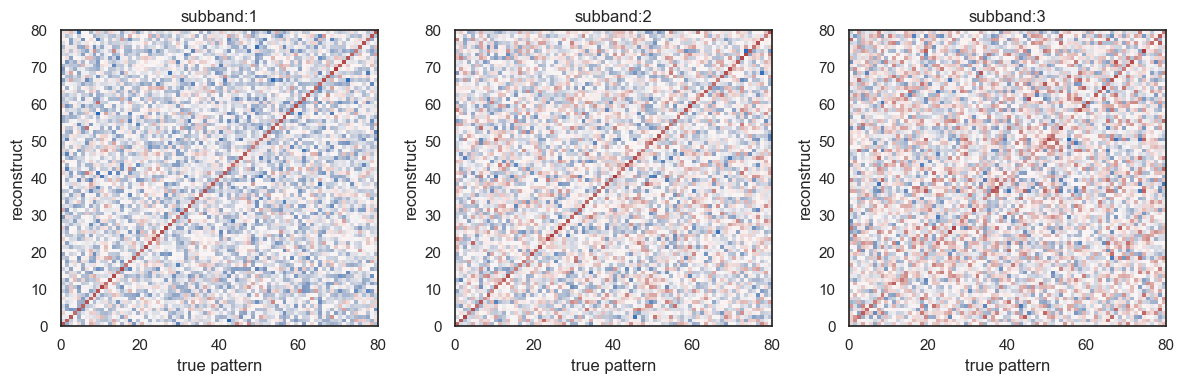

In [63]:
f,axs = plt.subplots(nrows=1,ncols=n_band,figsize=(4*n_band,4))

for i,ax in enumerate(axs):
    ax.pcolormesh(rhos[i],cmap='vlag')
    ax.set_title('subband:%s'%(i+1))
    ax.set_xlabel('true pattern')
    ax.set_ylabel('reconstruct')

plt.tight_layout()
plt.savefig('../images/recon-true.png',format='png',dpi=300)

# Get unifying response

In [10]:
X = np.concatenate([sub['wn']['X'][:, chnINX] for sub in wholeset])
y = np.concatenate([sub['wn']['y'] for sub in wholeset])


# reshape to class*block*chn*N
X_ = np.stack(X[y == i] for i in np.unique(y))
y_ = np.stack(y[y == i] for i in np.unique(y))

# split conditions
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_, y_,test_size=0.5,random_state=253)

X_train,X_test = np.concatenate(X_train, axis=0), np.concatenate(X_test, axis=0)
y_train,y_test = np.concatenate(y_train, axis=0), np.concatenate(y_test, axis=0)
S_train,S_test = np.stack([S[i-1] for i in y_train]),np.stack([S[i-1] for i in y_test])

/Users/shinanlin/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3377: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [17]:
from modeling import Code2EEG
code2EEG = Code2EEG(srate=srate,winLEN=winLEN,tmin=tmin,tmax=tmax,S=(S,np.unique(y)),estimator=p,padding=True,n_band=n_band,component=1)
code2EEG.fit(X_train,y_train)

In [19]:
R_ = code2EEG.predict(S_test)
R = code2EEG.enhancer.transform(X_test)

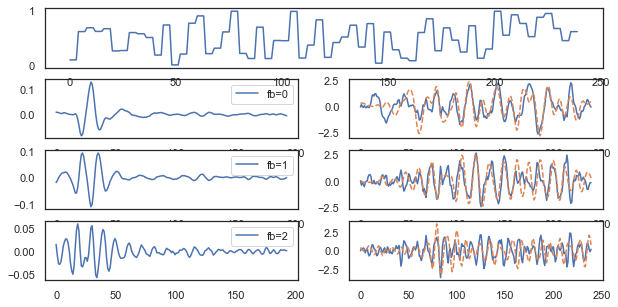

In [33]:
from scipy.stats import zscore
inx = np.unique(y_test)[1]
sns.set_theme(style='white')

f, axs = plt.subplots(nrows=n_band+1, ncols=2, figsize=(10, 5))

gs = axs[0,0].get_gridspec()
# remove the underlying axes
for ax in axs[0, :]:
    ax.remove()
axbig = f.add_subplot(gs[0, :])
axbig.plot(S[inx])

for i, ax in enumerate(axs[1:]):

    ax[0].plot(code2EEG.trf[i], label='fb=%s' % i)
    ax[1].plot(zscore(R[y_test==inx].mean(axis=0)[i].T))
    ax[1].plot(R_[y_test==inx].mean(axis=0)[i].T, linestyle='dashed')
    ax[0].legend(loc='upper right')

# Classification

In [77]:
from modeling import Match

code2EEG = Code2EEG(srate=srate,winLEN=winLEN,tmin=tmin,tmax=tmax,S=(S,np.unique(y)),estimator=0.96,padding=True,n_band=3,component=1)
code2EEG.fit(X_train,y_train)

R_ = code2EEG.predict(S_test)
X_ = code2EEG.enhancer.transform(X_test)

In [78]:
model = Match(winLEN=winLEN,srate=srate,lag=0.14)
model.fit(R_,y_test)
model.score(X_,y_test)

0.9479166666666666

In [79]:
score = []
winLENs = np.arange(0,1.1,0.1)
for win in tqdm(winLENs):

    model = Match(winLEN=win,srate=srate,lag=0.14)
    model.fit(R_,y_test)
    s = model.score(X_,y_test)
    score.append(s)

  0%|          | 0/11 [00:00<?, ?it/s]/Users/shinanlin/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/shinanlin/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/Users/shinanlin/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/shinanlin/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/shinanlin/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
100%|██████████| 11/11 [01:42<00:00,  9.28s/it]


Text(0, 0.5, 'Accuracy')

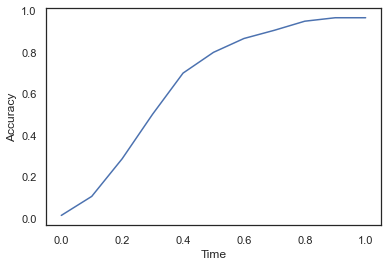

In [14]:

sns.set_theme(style='white')
f,ax = plt.subplots()
ax.plot(winLENs,score)
ax.set_xlabel('Time')
ax.set_ylabel('Accuracy')

# visualize filterbank

/var/folders/z8/m0rtcw1d0g37chf76qrvr9pw0000gn/T/ipykernel_97937/1785059768.py:19: RuntimeWarning: divide by zero encountered in log10
  ax1.plot((w/np.pi)*nyquistRate, 20 * np.log10(abs(h)))


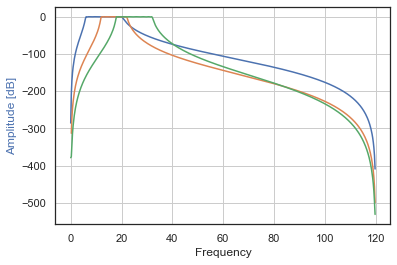

In [14]:
from scipy import signal
nyquistRate = srate//2


passband = [(4, 6), (10, 12), (16, 18),]
stopband = [(20, 25), (22, 24), (32, 34),]

fig, ax1 = plt.subplots()

for fbINX, (start,stop) in enumerate(zip(passband,stopband)):

    Wp = [start[1]/nyquistRate, stop[0]/nyquistRate]
    Ws = [start[0]/nyquistRate, stop[1]/nyquistRate]

    [N, Wn] = signal.cheb1ord(Wp, Ws, 3, 40)
    [B, A] = signal.cheby1(N, 0.5, Wn, 'bandpass')
    w, h = signal.freqz(B, A)

    ax1.plot((w/np.pi)*nyquistRate, 20 * np.log10(abs(h)))
    ax1.set_ylabel('Amplitude [dB]', color='b')
    ax1.set_xlabel('Frequency')
    ax1.grid(True)
